In [1]:
import sys  
sys.path.append('../models/')
import ExampleModels as em
import torchvision
from torchvision import transforms
import torch

In [2]:
def get_dataset():
    data_dir = '../dataset'
    train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
    test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)
    train_transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    test_transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    train_dataset.transform = train_transform
    test_dataset.transform = test_transform

    m=len(train_dataset)

    #train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])
    batch_size=32

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
    #valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)
    
    return train_dataset, test_dataset, train_loader, test_loader

train_dataset, test_dataset, train_loader, test_loader = get_dataset()

In [3]:
#TODO eval scaled on abblated data- compare to normal
import numpy as np
from skimage.metrics import peak_signal_noise_ratio
from skimage.metrics import structural_similarity as ssim # TODO maybe switch this to torchmetrics to run as batch
from skimage.metrics import mean_squared_error
def eval (ae, max_embed_size, min_p):
    print("running eval")
    n = 10 # TODO parameterize this? - how many embedding sizes to use for eval
    r = np.rint(np.linspace(max_embed_size,int(max_embed_size* min_p),n))
    encoder = ae.encoder
    decoder = ae.decoder
    device = ae.device
    avg_psnrs=[]
    avg_ssims=[]
    avg_mses=[]

    for i, embed_size in enumerate(r):
        #enumerate test dataset
        print(i, embed_size)
        psnrs = []
        ssims = []
        mses=[]
        for sample_idx in range(len(test_dataset)):
            img = test_dataset[sample_idx][0].unsqueeze(0).to(device)
            encoder.eval()
            decoder.eval()
            with torch.no_grad():
                # ablate embedding
                embedding = encoder(img)
                #create mask
                if embed_size < embedding.shape[1]:
                    embedding[0][-int(embedding.shape[1] - embed_size) :] = 0 
                rec_img  = decoder(embedding)
            ic= img.cpu().squeeze().numpy()
            rc=rec_img.cpu().squeeze().numpy()
            psnrs.append(float(peak_signal_noise_ratio(ic, rc)))
            ssims.append(float(ssim(ic,rc, data_range=1.0)))# 1.0 data range for sigmoid
            mses.append(float(mean_squared_error(ic,rc)))
        avg_psnrs.append(sum(psnrs)/len(psnrs))
        avg_ssims.append(sum(ssims)/len(ssims))
        avg_mses.append(sum(mses)/len(mses))
    
    return r, avg_psnrs, avg_ssims, avg_mses


In [4]:
# train distribution scaled model and evaluate
max_embed_size = 40
min_p = 0.2
ae = em.MNISTAutoEncoder(max_embed_size,use_sq_dr= True,dr_min_p= min_p, scale_output=True)

num_epochs = 40
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
    train_loss =ae.train_epoch(train_loader)
    val_loss = ae.test_epoch(test_loader)
    print('EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
    diz_loss['train_loss'].append(float(train_loss))
    diz_loss['val_loss'].append(float(val_loss))

diz_loss['r'], diz_loss['avg_psnrs'], diz_loss['avg_ssims'], diz_loss['avg_mses'] = eval(ae, max_embed_size, min_p)

Selected device: cuda
EPOCH 1/40 	 train loss 0.036073457449674606 	 val loss 0.024782387539744377
EPOCH 2/40 	 train loss 0.018426671624183655 	 val loss 0.020469699054956436
EPOCH 3/40 	 train loss 0.016143422573804855 	 val loss 0.01801876164972782
EPOCH 4/40 	 train loss 0.014910976402461529 	 val loss 0.01662164367735386
EPOCH 5/40 	 train loss 0.014296197332441807 	 val loss 0.01579100452363491
EPOCH 6/40 	 train loss 0.013642128556966782 	 val loss 0.014678058214485645
EPOCH 7/40 	 train loss 0.013209445402026176 	 val loss 0.014764577150344849
EPOCH 8/40 	 train loss 0.012889490462839603 	 val loss 0.013565531000494957
EPOCH 9/40 	 train loss 0.01263322215527296 	 val loss 0.012702258303761482
EPOCH 10/40 	 train loss 0.012312842532992363 	 val loss 0.013525794260203838
EPOCH 11/40 	 train loss 0.011983001604676247 	 val loss 0.012257265858352184
EPOCH 12/40 	 train loss 0.011834882199764252 	 val loss 0.012661897577345371
EPOCH 13/40 	 train loss 0.011767365969717503 	 val los

In [5]:
# train a normal model and evaluate

#max_embed_size = 40
#min_p = 0.2
ae = em.MNISTAutoEncoder(max_embed_size,use_sq_dr= True,dr_min_p= min_p, scale_output=False)

#num_epochs = 30
niz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
    train_loss =ae.train_epoch(train_loader)
    val_loss = ae.test_epoch(test_loader)
    print('EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
    niz_loss['train_loss'].append(float(train_loss))
    niz_loss['val_loss'].append(float(val_loss))
niz_loss['r'], niz_loss['avg_psnrs'], niz_loss['avg_ssims'], niz_loss['avg_mses'] = eval(ae, max_embed_size, min_p)

Selected device: cuda
EPOCH 1/40 	 train loss 0.04356282576918602 	 val loss 0.021352000534534454
EPOCH 2/40 	 train loss 0.01820427179336548 	 val loss 0.018113944679498672
EPOCH 3/40 	 train loss 0.01586170867085457 	 val loss 0.015909185633063316
EPOCH 4/40 	 train loss 0.014795457012951374 	 val loss 0.01566522940993309
EPOCH 5/40 	 train loss 0.01398295909166336 	 val loss 0.014185612089931965
EPOCH 6/40 	 train loss 0.013467272743582726 	 val loss 0.015206742100417614
EPOCH 7/40 	 train loss 0.012847733683884144 	 val loss 0.013464645482599735
EPOCH 8/40 	 train loss 0.012555332854390144 	 val loss 0.013301127590239048
EPOCH 9/40 	 train loss 0.012095792219042778 	 val loss 0.013765722513198853
EPOCH 10/40 	 train loss 0.011945619247853756 	 val loss 0.013932743109762669
EPOCH 11/40 	 train loss 0.011918998323380947 	 val loss 0.012857831083238125
EPOCH 12/40 	 train loss 0.011434881947934628 	 val loss 0.012688952498137951
EPOCH 13/40 	 train loss 0.011556711979210377 	 val loss

In [6]:
#no dropout
ae = em.MNISTAutoEncoder(max_embed_size,use_sq_dr= False,dr_min_p= min_p, scale_output=False)

#num_epochs = 30
iz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
    train_loss =ae.train_epoch(train_loader)
    val_loss = ae.test_epoch(test_loader)
    print('EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
    iz_loss['train_loss'].append(float(train_loss))
    iz_loss['val_loss'].append(float(val_loss))
iz_loss['r'], iz_loss['avg_psnrs'], iz_loss['avg_ssims'], iz_loss['avg_mses'] = eval(ae, max_embed_size, min_p)

Selected device: cuda
EPOCH 1/40 	 train loss 0.02917502261698246 	 val loss 0.015729617327451706
EPOCH 2/40 	 train loss 0.00957298744469881 	 val loss 0.013501745648682117
EPOCH 3/40 	 train loss 0.00800718367099762 	 val loss 0.011757073923945427
EPOCH 4/40 	 train loss 0.007185610476881266 	 val loss 0.01104086171835661
EPOCH 5/40 	 train loss 0.006615139544010162 	 val loss 0.010431705974042416
EPOCH 6/40 	 train loss 0.006190589163452387 	 val loss 0.009828238748013973
EPOCH 7/40 	 train loss 0.005854474846273661 	 val loss 0.009332065470516682
EPOCH 8/40 	 train loss 0.00558759830892086 	 val loss 0.009157153777778149
EPOCH 9/40 	 train loss 0.005373232997953892 	 val loss 0.008961840532720089
EPOCH 10/40 	 train loss 0.0052057793363928795 	 val loss 0.008504031226038933
EPOCH 11/40 	 train loss 0.005061094183474779 	 val loss 0.008429262787103653
EPOCH 12/40 	 train loss 0.004949452355504036 	 val loss 0.008299991488456726
EPOCH 13/40 	 train loss 0.004852123558521271 	 val los

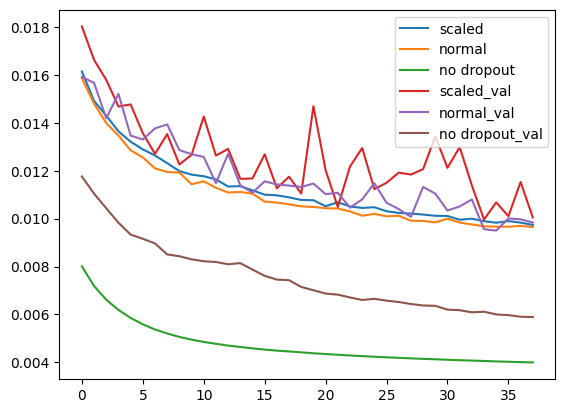

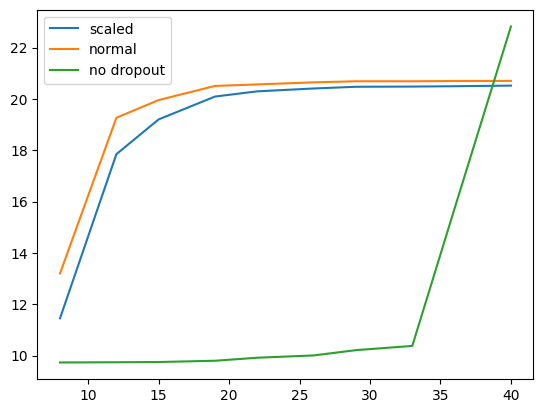

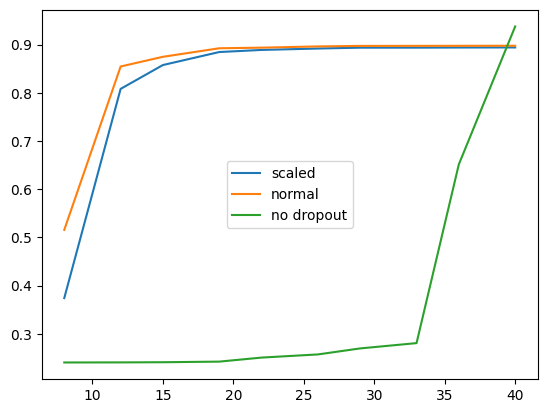

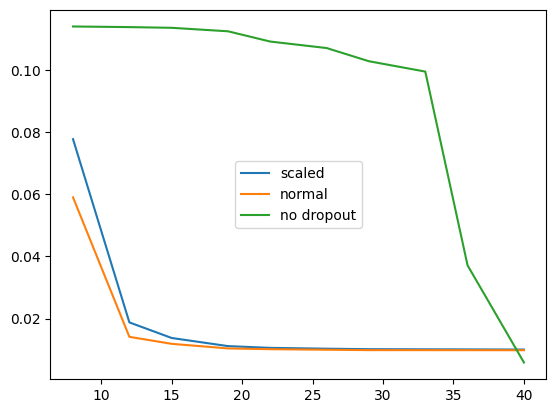

In [7]:
import matplotlib.pyplot as plt
start = 2
plt.plot(diz_loss['train_loss'][start:],label='scaled')
plt.plot(niz_loss['train_loss'][start:],label='normal')
plt.plot(iz_loss['train_loss'][start:],label='no dropout')
plt.plot(diz_loss['val_loss'][start:],label='scaled_val')
plt.plot(niz_loss['val_loss'][start:],label='normal_val')
plt.plot(iz_loss['val_loss'][start:],label='no dropout_val')
plt.legend()
plt.show()

#reconstruction error
plt.plot(diz_loss['r'], diz_loss['avg_psnrs'],label='scaled')
plt.plot(niz_loss['r'], niz_loss['avg_psnrs'],label='normal')
plt.plot(iz_loss['r'], iz_loss['avg_psnrs'],label='no dropout')
plt.legend()
plt.show()

plt.plot(diz_loss['r'], diz_loss['avg_ssims'],label='scaled')
plt.plot(niz_loss['r'], niz_loss['avg_ssims'],label='normal')
plt.plot(iz_loss['r'], iz_loss['avg_ssims'],label='no dropout')
plt.legend()
plt.show()

plt.plot(diz_loss['r'], diz_loss['avg_mses'],label='scaled')
plt.plot(niz_loss['r'], niz_loss['avg_mses'],label='normal')
plt.plot(iz_loss['r'], iz_loss['avg_mses'],label='no dropout')
plt.legend()
plt.show()

In [ ]:
# TODO eval a normal autoencoder with normal dropout

# todo eval with random abblation on dropout